# Artificial Neural Networks and Deep Learning


---


# Homework 1 - Data wrangling


## ⚙️ Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import cv2
import keras_cv
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🗺️ Data exploration 

In [2]:
# Load Data
data = np.load('data/training_set.npz')
# model_with_augmentation_and_k-fold.ipynb

x = data['images']
y = data['labels']

np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([1052, 2381, 1285, 2226, 1049, 1393, 2530, 1843], dtype=int64))

In [3]:
x.shape

(13759, 96, 96, 3)

In [4]:
# Labels dictionary
labels_dict = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

In [5]:
class_count = {}
for i in labels_dict:
    class_count[i] = np.unique(y, return_counts=True)[1][i]

class_count

{0: 1052, 1: 2381, 2: 1285, 3: 2226, 4: 1049, 5: 1393, 6: 2530, 7: 1843}

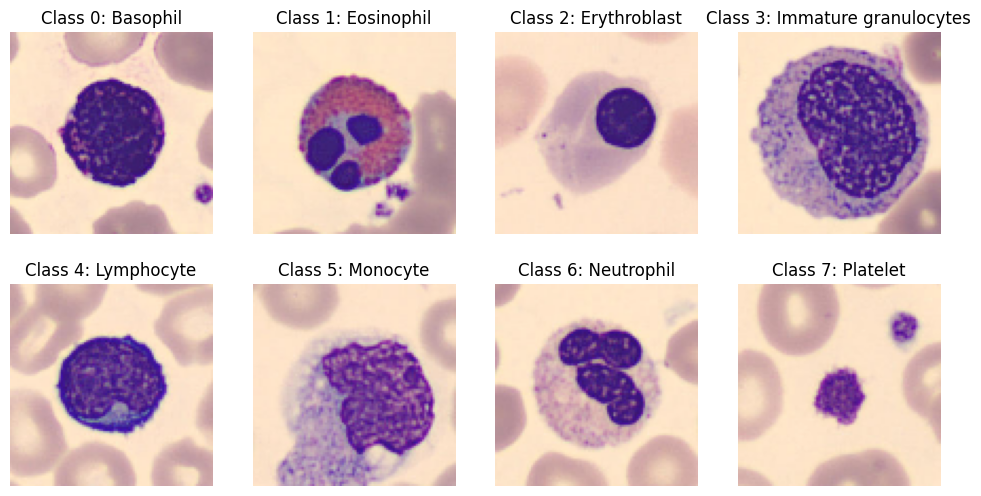

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.reshape((-1,))
# show one image per each class
for i in range(8):
    axs[i].set_title(f'Class {i}: {labels_dict[i]}')
    axs[i].axis('off')
    sample_cont = 0
    while True:
        curr_class = y[sample_cont][0]
        if(i != curr_class):
            sample_cont += 1
        else:
            break
    axs[i].imshow(x[sample_cont])
    
plt.show()

In [7]:
# reshape x to apply PCA
x_flat = x.reshape(x.shape[0], -1)

# Reduce dimensions to 2 to plot data
pca = PCA(n_components=2)
features_pca = pca.fit_transform(x_flat)

In [8]:
pca.components_.shape

(2, 27648)

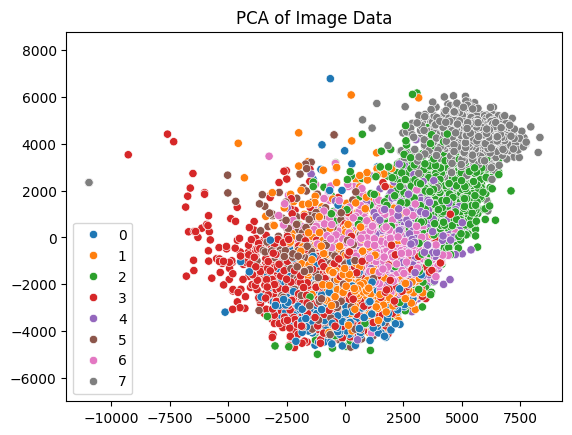

In [9]:
# Plot Principal components
plt.title('PCA of Image Data')
plt.axis('equal')
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=y.flatten(),palette='tab10')
plt.show()

The points that are further away are outliers, so now let's find them

In [10]:
# Calculate euclidian distance from each sample to the origin in the PCA space
distances = np.linalg.norm(features_pca, axis=1)

# Let's find the 20 samples that are further away from the origin
num_outliers = 20
outlier_indices = np.argsort(distances)[-num_outliers:]
outlier_indices

array([12682, 12681, 12680, 12679, 12678, 12677, 12664, 12676, 12674,
       12673, 12672, 12671, 12670, 12669, 12668, 12667, 12666, 12675,
       12854, 12776], dtype=int64)

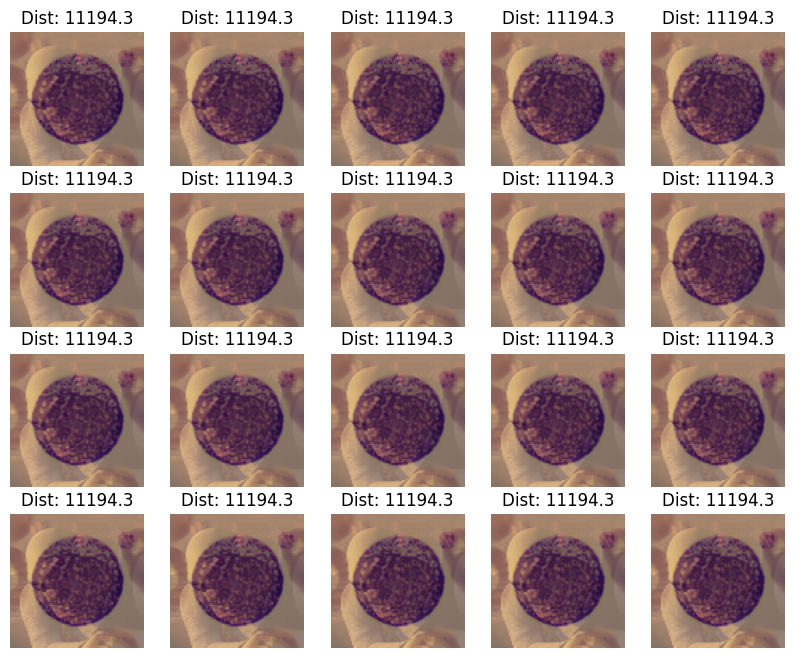

In [11]:
# show some of these outliers
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
axs = axs.reshape((-1,))
for i,idx in enumerate(outlier_indices):
    axs[i].imshow(x[idx])
    axs[i].axis('off')
    axs[i].set_title(f'Dist: {round(distances[idx], 1)}')

### 🧐 🧐 🧐 🧐 This all seem to be shrek images merged with cell images

Luckily it seems that all of these Shreks are positioned at the same distance from the origin. This makes it easier to identify them.

In [12]:
print("Distances of the outliers:", distances[outlier_indices])
sherk_distance = round(distances[outlier_indices][-1])
sherk_distance

Distances of the outliers: [11194.34709185 11194.34709185 11194.34709185 11194.34709185
 11194.34709185 11194.34709185 11194.34709185 11194.34709185
 11194.34709185 11194.34709185 11194.34709185 11194.34709185
 11194.34709185 11194.34709185 11194.34709185 11194.34709185
 11194.34709185 11194.34709185 11194.34709185 11194.34709185]


11194

but before deleting the shreks, I realized by pure mistake (I got rickrolled) I found another meme inside the data, and this one is not as far as the other one...

Text(0.5, 1.0, 'Dist: 4411.4')

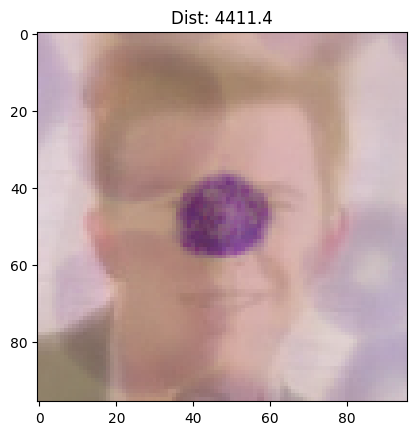

In [13]:
plt.imshow(x[-1])
plt.title(f'Dist: {round(distances[-1], 1)}')


And mapping the distances I found more of these

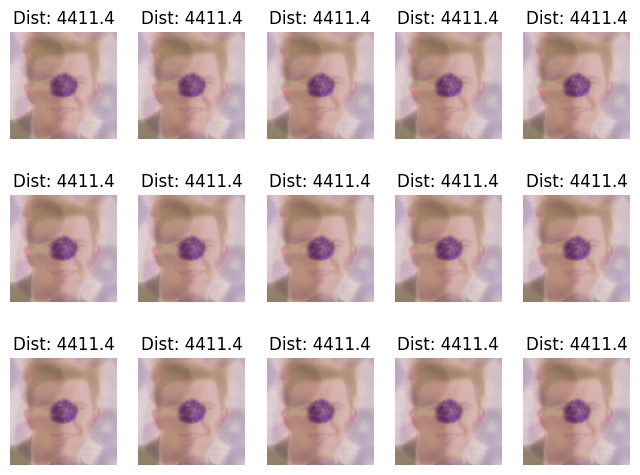

In [14]:
rick_distance = round(distances[-1])
ricks = np.where((distances > rick_distance) & (distances < rick_distance+1))[0]

#select 10 random samples from the ricks
rick_indices = np.random.choice(ricks, 15)
# show some of these ricks
fig, axs = plt.subplots(3, 5, figsize=(8, 6))
axs = axs.reshape((-1,))
for i, idx in enumerate(rick_indices):
    axs[i].imshow(x[idx])
    axs[i].axis('off')
    axs[i].set_title(f'Dist: {round(distances[idx], 1)}')

So, in case there are more memes hidden around the data I would like to group by large number of points around the same distance

In [15]:
distance_count = np.unique(np.floor(distances), return_counts=True)
distance_count

(array([   38.,    47.,    49., ...,  9365.,  9919., 11194.]),
 array([   1,    1,    1, ...,    1,    1, 1600], dtype=int64))

In [16]:
# Delete distances that have low count
thrs = 8
distance_count = (distance_count[0][distance_count[1] > thrs], distance_count[1][distance_count[1] > thrs])
distance_count

(array([ 1872.,  1922.,  2023.,  2172.,  2275.,  2325.,  2352.,  2387.,
         2397.,  2425.,  2428.,  2543.,  2572.,  2632.,  2640.,  2757.,
         2768.,  2966.,  4411., 11194.]),
 array([   9,    9,    9,    9,    9,    9,    9,    9,    9,    9,   10,
           9,   10,    9,    9,    9,    9,   10,  200, 1600], dtype=int64))

So, no, no more memes, and to sum up, there are:

- 200 rickrolls
- 1600 shreks

= 1800 trash samples

Now, delete them

## 🧹 Data Cleaning

In [17]:
rick_distance, sherk_distance

(4411, 11194)

In [18]:
# Identify the samples which distance is less than the outlier distance
ricks = np.where((distances > rick_distance) & (distances < rick_distance+1))[0]
shreks = np.where((distances > sherk_distance) & (distances < sherk_distance+1))[0]

# memes indices
meme_indices = np.concatenate([ricks, shreks])

print("Number of trash samples:")
print(meme_indices.shape[0])

print("Remaining data:")
print(x.shape[0] - meme_indices.shape[0])

Number of trash samples:
1800
Remaining data:
11959


In [19]:
# keep only the clean samples from x and y
x_clean = np.delete(x, meme_indices, axis=0)
y_clean = np.delete(y, meme_indices, axis=0)

x_clean.shape, y_clean.shape

((11959, 96, 96, 3), (11959, 1))

Check with PCA the data distribution again

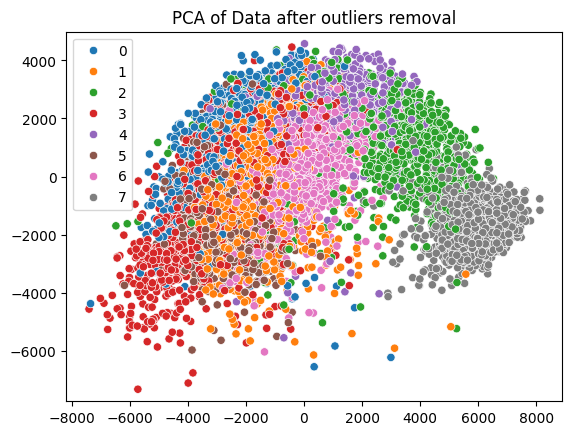

In [21]:
# reshape x to apply PCA
x_flat = x_clean.reshape(x_clean.shape[0], -1)

# Reduce dimensions to 2 to plot data
pca = PCA(n_components=2)
features_pca = pca.fit_transform(x_flat)

# Plot Principal components
plt.title('PCA of Data after outliers removal')
plt.axis('equal')
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=y_clean.flatten(),palette='tab10')
plt.show()

In [22]:
# Normalize data to the range [0, 1]
x_clean = (x_clean / 255).astype('float32')

## 💾 Save clean data

In [290]:
np.savez('clean_data.npz', images=x_clean, labels=y_clean)

## 💰 Data enriching

In [291]:
def get_siloutte(image, THRESH_VALUE_STRICT, plot=False, gray=False):
    
    THRESH_BINARY = cv2.THRESH_BINARY    
    THRESH_MAX_VALUE = 255

    # Transition into shades of gray
    if not gray:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Create strict mask
    _, mask = cv2.threshold(
        gray, THRESH_VALUE_STRICT, THRESH_MAX_VALUE, THRESH_BINARY
    )
    
    # Generate intersection between strict mask and original image
    siloutte = image.copy()
    siloutte[mask == 255] = 255 # overlapping the strict mask with the white pixels

    if plot:
        plt.figure(figsize=(12,4))
        plt.subplot(131), plt.imshow(image, cmap='gray'), plt.title('original'), plt.axis('off')
        plt.subplot(132), plt.imshow(mask, cmap='gray'), plt.title('strict_mask'), plt.axis('off')
        plt.subplot(133), plt.imshow(siloutte, cmap='gray'), plt.title('siloutte'), plt.axis('off')

    return siloutte

In [292]:
def get_gradient(img):
    # Sobel operator implementation for axises X and Y
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    # Gradient calculation
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Gradient normalization
    gradient_magnitude = np.uint8(gradient_magnitude / gradient_magnitude.max() * 255)

    # Invert colors for better visualization 
    inverted_edges = cv2.bitwise_not(gradient_magnitude)

    return inverted_edges

In [293]:
def compare_methods(image):
    image = (image * 255).astype(np.uint8)

    siloutte = get_siloutte(image, 120, gray=False, plot=False)

    # Transition into shades of gray
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Gradient calculation
    gradient_orig = get_gradient(siloutte)
    gradient_gray = get_gradient(gray)

    # equalized = cv2.equalizeHist(gradient_orig) # this doesn't work
    equalized = cv2.equalizeHist(gradient_gray)    

    siloutte_grad = get_siloutte(gradient_gray, 180, gray=True, plot=False)
    siloutte_grad_eq = get_siloutte(equalized, 60, gray=True, plot=False)

    plt.figure(figsize=(15, 5))
    plt.subplot(241), plt.imshow(image, cmap='gray'), plt.title('Original'), plt.axis('off')
    plt.subplot(242), plt.imshow(gray, cmap='gray'), plt.title('Original grayscale'), plt.axis('off')
    plt.subplot(243), plt.imshow(siloutte, cmap='gray'), plt.title('Siloutte'), plt.axis('off')
    plt.subplot(244), plt.imshow(gradient_orig, cmap='gray'), plt.title('Gradient Magnitude of siloutte'), plt.axis('off')
    
    plt.subplot(245), plt.imshow(gradient_gray, cmap='gray'), plt.title('Gradient of grayscale'), plt.axis('off')
    plt.subplot(246), plt.imshow(siloutte_grad, cmap='gray'), plt.title('Siloutte gradient gray'), plt.axis('off')
    plt.subplot(247), plt.imshow(equalized, cmap='gray'), plt.title('Equalized Gradient grayscale'), plt.axis('off')
    plt.subplot(248), plt.imshow(siloutte_grad_eq, cmap='gray'), plt.title('siloutte equalized'), plt.axis('off')
    

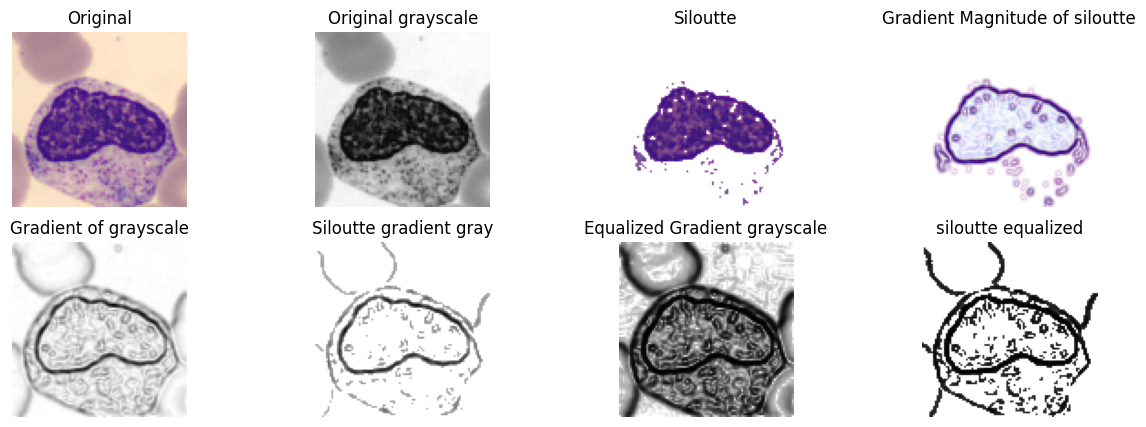

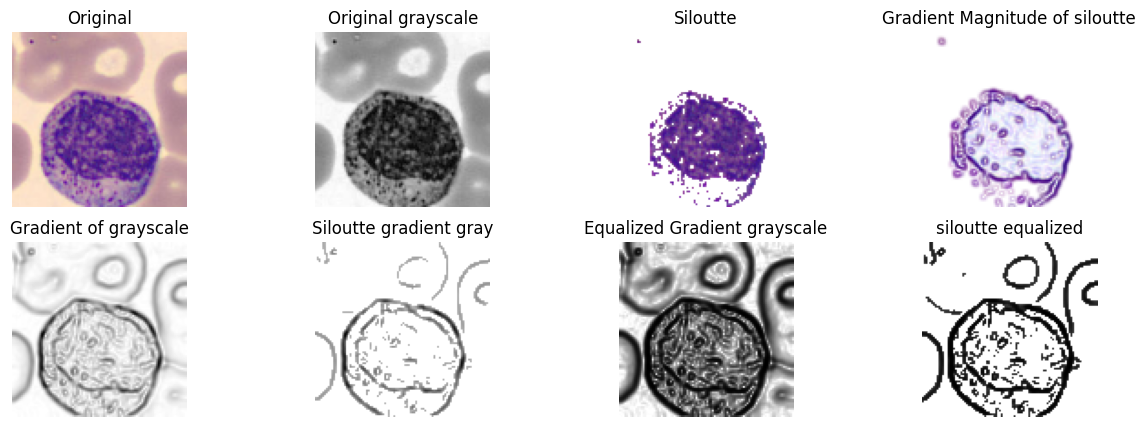

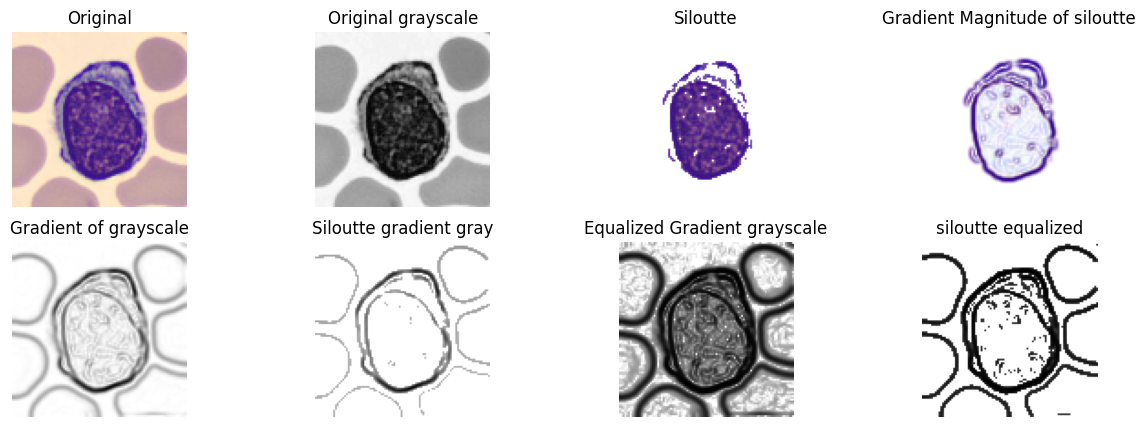

In [294]:
# choose a random image to apply edge highlighting
for i in range(3):
    rand_idx = np.random.randint(0, x_clean.shape[0])
    img = x_clean[rand_idx]
    compare_methods(img)


Out of these methods the one that seem to give more importance to the cell, highlighting its features is the Gradient magnitude of the siloutte. We'll try to create a dataset out of these

In [295]:
def edge_highlighting(image):
    image = (image * 255).astype(np.uint8)
    siloutte = get_siloutte(image, 120, gray=False, plot=False)
    gradient_orig = get_gradient(siloutte)
    return gradient_orig

In [296]:
x_enriched = np.array(list(map(edge_highlighting, x_clean)))
x_clean.shape, x_enriched.shape

C:\Users\angel\AppData\Local\Temp\ipykernel_25736\2820248944.py:10: RuntimeWarning: invalid value encountered in divide
  gradient_magnitude = np.uint8(gradient_magnitude / gradient_magnitude.max() * 255)
C:\Users\angel\AppData\Local\Temp\ipykernel_25736\2820248944.py:10: RuntimeWarning: invalid value encountered in cast
  gradient_magnitude = np.uint8(gradient_magnitude / gradient_magnitude.max() * 255)


((11959, 96, 96, 3), (11959, 96, 96, 3))

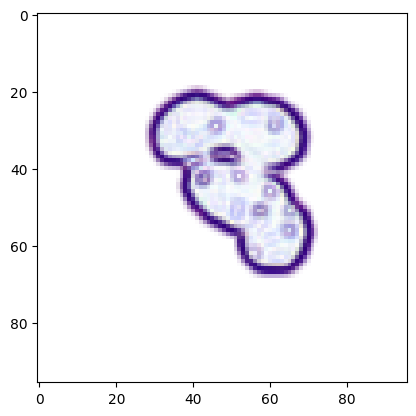

In [297]:
plt.imshow(x_enriched[2])

## 💾 Save enriched data

In [298]:
np.savez('edge_data.npz', images=x_enriched, labels=y_clean)

## ➕ Data Augmentation

With all deletion we made, data is more imbalanced than ever.

In [299]:
class_count_clean = {}
for i in labels_dict:
    class_count_clean[i] = np.unique(y_clean, return_counts=True)[1][i]

class_count_clean

{0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}

class `6: 'Neutrophil'` has the most images with 2330 samples. Have to augment to level all other classes to this one

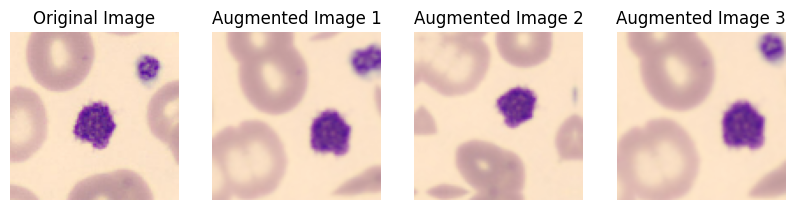

In [ ]:
# Define a sequential model for image augmentation
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
], name='Augmentation')

# Set up the figure and grid layout for displaying images
fig, axs = plt.subplots(1, 4, figsize=(10, 10))

img = x_clean[0] # Select the first image from the dataset for example

# Display the original image
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
axs[1].imshow(augmented_img)
axs[1].axis('off')
axs[1].set_title('Augmented Image 1')

# Apply augmentation and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
axs[2].imshow(augmented_img)
axs[2].axis('off')
axs[2].set_title('Augmented Image 2')

# Apply augmentation and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
axs[3].imshow(augmented_img)
axs[3].axis('off')
axs[3].set_title('Augmented Image 3')

plt.show()

This is the augmentation layer that will be used for all classes to reach 2330 samples

In [301]:
samples_per_class = max(class_count_clean.values()) # 2330
samples_per_class

2330

In [302]:
new_x = []
new_y = []
# Sweep for every class
for clas in class_count_clean:
    print(f'Augmenting class {clas}...')
    # Filter images of current class
    class_images = x_clean[y_clean.flatten() == clas]
    while class_count_clean[clas] < samples_per_class:
        # Select a random image from the current class
        random_index = np.random.randint(0, class_images.shape[0])
        original_img = class_images[random_index]
        
        # Apply augmentation layer
        augmented_img = np.clip(augmentation(original_img), 0., 1.)
        
        # Add new image and its label to data
        new_x.append(augmented_img)
        new_y.append(clas)
        class_count_clean[clas] += 1

# Concatenate the augmented data into the whole data
new_x = np.array(new_x)
new_y = np.array(new_y).reshape(-1, 1)

x_aug = np.concatenate([x_clean, new_x], axis=0)
y_aug = np.concatenate([y_clean, new_y], axis=0)


Augmenting class 0...
Augmenting class 1...
Augmenting class 2...
Augmenting class 3...
Augmenting class 4...
Augmenting class 5...
Augmenting class 6...
Augmenting class 7...


In [303]:
class_count_clean

{0: 2330, 1: 2330, 2: 2330, 3: 2330, 4: 2330, 5: 2330, 6: 2330, 7: 2330}

In [304]:
np.unique(y_aug, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2330, 2330, 2330, 2330, 2330, 2330, 2330, 2330], dtype=int64))

## 💾 Save augmented data

In [305]:
np.savez('aug_data.npz', images=x_aug, labels=y_aug)

let's apply to all augmented data the edge highlighting algorithm

In [306]:
x_aug_edge = np.array(list(map(edge_highlighting, x_aug)))

x_aug.shape, x_aug_edge.shape, y_aug.shape

C:\Users\angel\AppData\Local\Temp\ipykernel_25736\2820248944.py:10: RuntimeWarning: invalid value encountered in divide
  gradient_magnitude = np.uint8(gradient_magnitude / gradient_magnitude.max() * 255)
C:\Users\angel\AppData\Local\Temp\ipykernel_25736\2820248944.py:10: RuntimeWarning: invalid value encountered in cast
  gradient_magnitude = np.uint8(gradient_magnitude / gradient_magnitude.max() * 255)


((18640, 96, 96, 3), (18640, 96, 96, 3), (18640, 1))

In [307]:
x_aug_edge[-1].max()

255

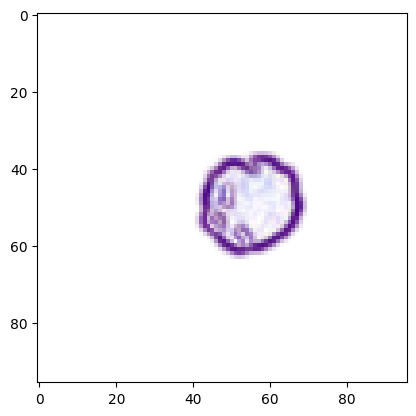

In [308]:
plt.imshow(x_aug_edge[-1])

In [309]:
# and save it

np.savez('aug_edge_data.npz', images=x_aug_edge, labels=y_aug)